# Fingerprint Recognition 
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

The purpose of this task is to make a simplified version of Fingerprint ID, which is just identifying which finger is used in the image.


The task is the following:

- Select and implement suitable data preprocessing techniques;
- Build a CNN model;
- Apply CNN to solve an image classification problem;
- Use of data augmentation to improve model’s performance;
- Estimate the speed of inference of your model.


### Data


The data is in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

#### Data extracting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/MyDrive/Копия task 2.zip" "task 2.zip"

In [ ]:
!unzip "task 2.zip"

Archive:  task 2.zip
 extracting: test.zip                
 extracting: train.zip               


In [ ]:
!unzip test.zip 
!unzip train.zip

### Datasets loading & Preprocessing & Data augmentation

In [ ]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms.functional import crop
from PIL import Image
import os
import random 

In [ ]:
# get the absolute filenames of images in the directory
def get_filenames(img_dir):
    image_files = []
    for img_name in os.listdir(img_dir):
            img_filename = os.path.join(img_dir, img_name)
            if os.path.isfile(img_filename):
                image_files.append(img_filename)
    return image_files


# define a class for an image dataset 
class ImageDataset(Dataset):
    def __init__(self, img_filenames, transform=None, aug_transform=None):
        self.img_filenames = img_filenames
        self.transform = transform
        self.aug_transform = aug_transform

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, i):
        img_path = self.img_filenames[i]
        image = Image.open(img_path)
        label = int(img_path.split("_")[1].split(".")[0])
    
        if self.transform:
            image = self.transform(image)

        if self.aug_transform:
            image = self.aug_transform(image)
 
        return image, label

In [ ]:
train_batch_size = 64
test_batch_size = 64
val_batch_size = 64
min_h = 103
min_w = 96
top, left = 2, 2


# data preprocessing
transform = transforms.Compose([
    transforms.Resize((min_h, min_w)), 
    transforms.Lambda(lambda img: crop(img, top, left, 
                                       min_h - 13, min_w - 6)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# put data augmentation 
data_augmentation = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomRotation((-5, 5), fill=1),
        ], p = 0.6)
])


# get the absolute filenames of images for train and test directories
train_images = get_filenames('/content/train/')
test_images = get_filenames('/content/content/test/')

# split the train images to train (80%) and validation (20%)
split = int(len(train_images) * 0.8)
random.shuffle(train_images)
train_images, val_images = train_images[:split], train_images[split:]


# define train set, apply preprocessing and random data augmentation
train_dataset = ImageDataset(train_images, 
                             transform=transform, 
                             aug_transform=data_augmentation)

# define validation data set and apply preprocessing
val_dataset = ImageDataset(val_images, 
                           transform=transform)

# define test data set and apply preprocessing
test_dataset = ImageDataset(test_images, 
                            transform=transform)

In [ ]:
# define the loader of train data set
train_dataloader = DataLoader(train_dataset, 
                               batch_size=train_batch_size, 
                               shuffle=True)

# define the loader of train data set
val_dataloader = DataLoader(val_dataset, 
                            batch_size=val_batch_size)

# define the loader of test data set
test_dataloader = DataLoader(test_dataset, 
                             batch_size=test_batch_size)

#### Check the class distributions in the data sets

In [ ]:
from collections import Counter


# compute the number of each class in the data set
def check_class_balance(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label)
    counts = Counter(labels)
    return counts

In [ ]:
# specify the labels
label_titles = ['left_thumb', 'left_index', 'left_middle', 'left_ring', 
               'left_little', 'right_thumb', 'right_index', 
               'right_middle', 'right_ring', 'right_little']

# check the class balance in train data set
train_balance = check_class_balance(train_dataset)

print('Train set balance:\n')
for idx, count in train_balance.items():
    print('{}: count {}'.format(label_titles[idx], count))

Train set balance:

right_thumb: count 1559
right_little: count 1524
right_middle: count 1554
left_little: count 1551
left_ring: count 1546
right_index: count 1568
left_middle: count 1556
left_index: count 1540
right_ring: count 1564
left_thumb: count 1568


In [ ]:
# check the class balance in validation data set
val_balance = check_class_balance(val_dataset)

print('Validation set balance:\n')
for idx, count in val_balance.items():
    print('{}: count {}'.format(label_titles[idx], count))

Validation set balance:

left_middle: count 394
right_index: count 372
right_middle: count 384
left_index: count 381
right_little: count 402
left_ring: count 406
left_thumb: count 382
right_ring: count 382
right_thumb: count 382
left_little: count 398


In [ ]:
# check the class balance in test data set
test_balance = check_class_balance(test_dataset)

print('Test set balance:\n')
for idx, count in test_balance.items():
    print('{}: count {}'.format(label_titles[idx], count))

Test set balance:

right_ring: count 1406
right_middle: count 1369
left_middle: count 1479
left_little: count 1372
right_index: count 1305
left_thumb: count 1617
left_index: count 1415
left_ring: count 1498
right_little: count 1344
right_thumb: count 1467


As can be observed, the train, validation and test data sets are balanced. Therefore, to further evaluate the model's performance, we can use the accuracy score.

#### Visualization of the preprocessed data

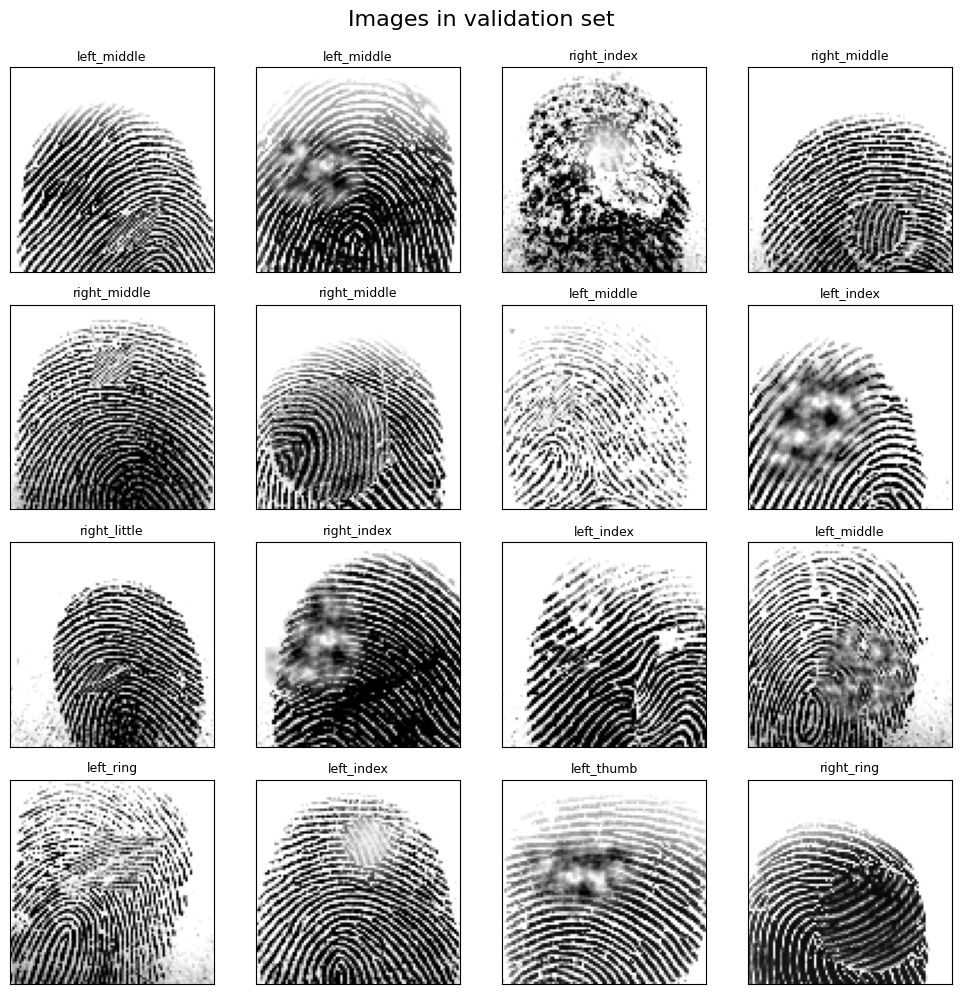

In [ ]:
import matplotlib.pyplot as plt


# get one batch of validation images
images, labels = next(iter(val_dataloader))

# check the results of preprocessing

fig = plt.figure(figsize=(10, 10))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].numpy().transpose(1,2,0), cmap='gray')
    ax.set_title(label_titles[labels[i]], fontsize=9)

plt.suptitle('Images in validation set', 
             fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

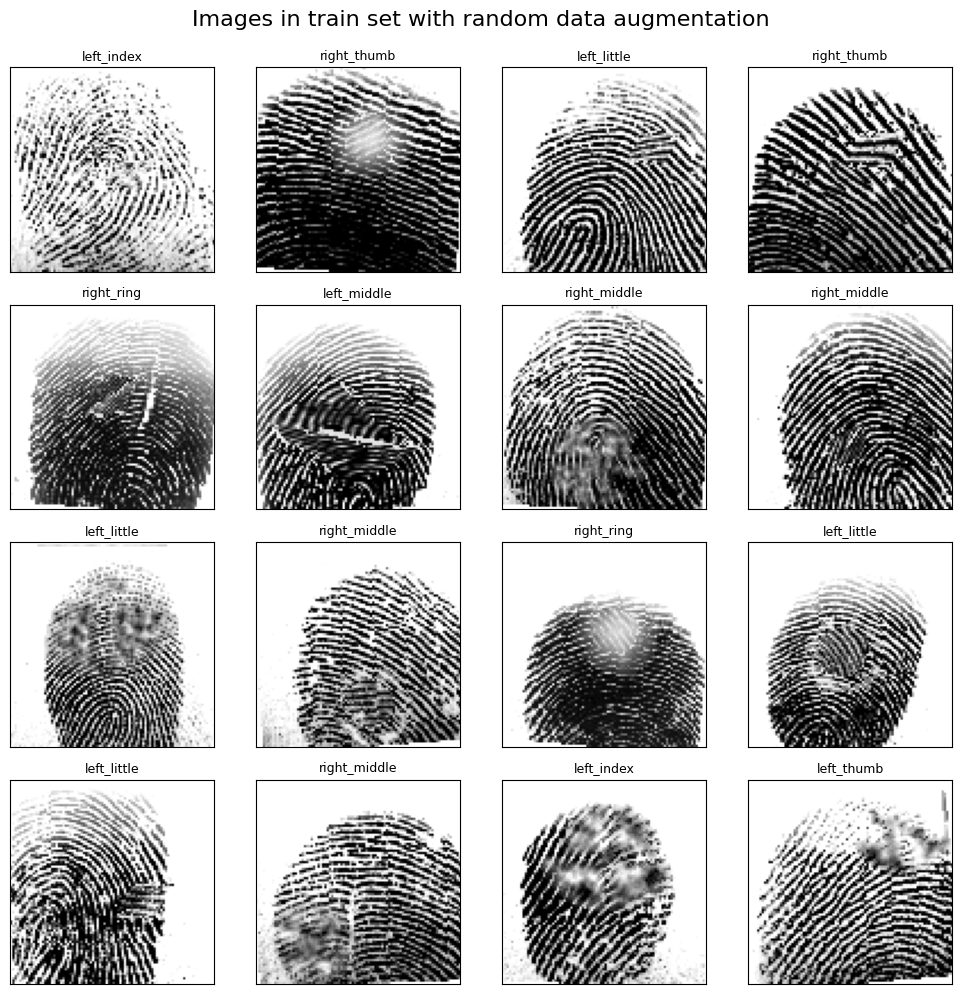

In [ ]:
# check the results of preprocessing and data augmentation

# get one batch of train images
images, labels = next(iter(train_dataloader))

fig = plt.figure(figsize=(10, 10))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].numpy().transpose(1,2,0), cmap='gray')
    ax.set_title(label_titles[labels[i]], fontsize=9)

plt.suptitle('Images in train set with random data augmentation', 
             fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

### Building CNN Model 

In [ ]:
class CNN(nn.Module):
    def __init__(self, output=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential( # input 90 * 90 * 1
            nn.Conv2d(1, 32, 5, 3, 1), # 32 * 30 * 30
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 5, 3, 1), # 32 * 10 * 10
            nn.ReLU(),
            nn.BatchNorm2d(32), 
            nn.MaxPool2d(2, 2), # 32 * 5 * 5
            nn.Dropout(0.4)
        )

        self.linear1 = nn.Sequential(
            nn.Linear(32 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, output) 
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN(output=10).to(device)

print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.4, inplace=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


#### Early Stopping

In [ ]:
import operator
import numpy as np

# define a class for early stopping 
# stop training if validation loss stops decrease after given patience
class EarlyStopping():
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.min_val_loss = np.inf 
        self.operation = operator.gt 
    
    def __call__(self, val_loss):
        delta = (val_loss - self.min_val_loss)

        if self.operation(delta, self.min_delta):
            self.counter += 1
        else:
            self.counter = 0
            self.min_val_loss = val_loss

        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop

#### Training & Validation

In [ ]:
from tqdm import tqdm


# define the learning rate and number of epochs to train the model for
lr = 0.001
epochs = 100
patience = 5

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr)

# define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', 
                                                          factor=0.7, 
                                                          patience=3)

# define the early stopping
early_stopping = EarlyStopping(patience=patience)


# define the train function to train the model
def train(model, device, train_loader, criterion, opt, epoch):
    # set the model to the training mode
    model.train()
    train_loss = 0
    bar = tqdm(train_loader)
    # iterate through the data loader
    for input, target in bar:
        input, target = input.to(device), target.to(device)
        opt.zero_grad()

        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        opt.step()
        train_loss += loss.item()
        
    # print and return the average loss 
    avg_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}: loss = {avg_loss}')

    return avg_loss
    

# define the validation function 
def evaluate(model, device, val_loader, criterion, opt):
    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        # iterate over validation data
        for input, target in val_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            val_loss += loss.item()
        
            # convert output probabilities to predicted class
            _, preds = torch.max(output, dim=1)

            correct += (preds == target).sum().item()

    # calculate and print validation accuracy and average validation loss
    avg_val_loss = val_loss / len(val_loader)
    acc = correct / len(val_loader.dataset)
    print(f'val loss = {avg_val_loss}, val accuracy = {acc}')
    
    # return the average validation loss and accuracy
    return avg_val_loss, acc



losses = []
val_losses = []
val_accs = []
for epoch in range(epochs):
    best_acc = 0
    # train the model
    train_loss = train(model, device, train_dataloader, 
                       criterion, opt, epoch)
    losses.append(train_loss)

    # evaluate the model on the validation set
    val_loss, val_acc = evaluate(model, device, val_dataloader, 
                                 criterion, opt)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # update the learning rate if validation loss does not decrease
    lr_scheduler.step(val_loss)

    if early_stopping(val_loss):
            print('\nEarly stopping\n')
            break
            
    # save the model with the highest accuracy score on validation set
    if val_acc > best_acc:
        torch.save(model.state_dict(), 'best-model.pt')
        best_acc = val_acc


100%|██████████| 243/243 [00:11<00:00, 20.49it/s]


Epoch 1/100: loss = 1.5302977346098472
val loss = 1.150743706304519, val accuracy = 0.5869173319598249


100%|██████████| 243/243 [00:11<00:00, 20.93it/s]


Epoch 2/100: loss = 1.0638120839134655
val loss = 1.0503666010059294, val accuracy = 0.6255472572753026


100%|██████████| 243/243 [00:11<00:00, 20.83it/s]


Epoch 3/100: loss = 0.8268071682855426
val loss = 0.7355091835631699, val accuracy = 0.7478753541076487


100%|██████████| 243/243 [00:11<00:00, 20.89it/s]


Epoch 4/100: loss = 0.6758150798057823
val loss = 0.6069103108077752, val accuracy = 0.7991243883595158


100%|██████████| 243/243 [00:11<00:00, 20.98it/s]


Epoch 5/100: loss = 0.5480441157955201
val loss = 0.5568286068126803, val accuracy = 0.8132886943085244


100%|██████████| 243/243 [00:11<00:00, 21.72it/s]


Epoch 6/100: loss = 0.45437955604904473
val loss = 0.430965856450503, val accuracy = 0.8619624002060262


100%|██████████| 243/243 [00:11<00:00, 21.86it/s]


Epoch 7/100: loss = 0.3912698752227634
val loss = 0.3940083303901016, val accuracy = 0.8732938449652331


100%|██████████| 243/243 [00:10<00:00, 22.15it/s]


Epoch 8/100: loss = 0.34427110890670076
val loss = 0.405088016488513, val accuracy = 0.8665979912438836


100%|██████████| 243/243 [00:10<00:00, 22.14it/s]


Epoch 9/100: loss = 0.3125035263935234
val loss = 0.2907407503636157, val accuracy = 0.9075457120782899


100%|██████████| 243/243 [00:11<00:00, 21.86it/s]


Epoch 10/100: loss = 0.27769134178328414
val loss = 0.27862685992092384, val accuracy = 0.9165593613185681


100%|██████████| 243/243 [00:11<00:00, 21.60it/s]


Epoch 11/100: loss = 0.25732778987766786
val loss = 0.2706480092201077, val accuracy = 0.9163018284831316


100%|██████████| 243/243 [00:11<00:00, 21.06it/s]


Epoch 12/100: loss = 0.22680904569081317
val loss = 0.24458275588809467, val accuracy = 0.928920937419521


100%|██████████| 243/243 [00:11<00:00, 21.03it/s]


Epoch 13/100: loss = 0.21156967149227243
val loss = 0.23896680063888676, val accuracy = 0.9335565284573784


100%|██████████| 243/243 [00:11<00:00, 20.74it/s]


Epoch 14/100: loss = 0.204254201609534
val loss = 0.23438430040097627, val accuracy = 0.9356167911408705


100%|██████████| 243/243 [00:11<00:00, 20.89it/s]


Epoch 15/100: loss = 0.19088934315943423
val loss = 0.23256805850589862, val accuracy = 0.9371619881534896


100%|██████████| 243/243 [00:11<00:00, 20.40it/s]


Epoch 16/100: loss = 0.17818406351493218
val loss = 0.23724315364341267, val accuracy = 0.9381921194952356


100%|██████████| 243/243 [00:11<00:00, 20.42it/s]


Epoch 17/100: loss = 0.16918260441640767
val loss = 0.2215790332096522, val accuracy = 0.9399948493432912


100%|██████████| 243/243 [00:11<00:00, 20.71it/s]


Epoch 18/100: loss = 0.17317932542152856
val loss = 0.20137112007522193, val accuracy = 0.9469482359000773


100%|██████████| 243/243 [00:11<00:00, 20.38it/s]


Epoch 19/100: loss = 0.15223848710886737
val loss = 0.20713461605740374, val accuracy = 0.950296162760752


100%|██████████| 243/243 [00:11<00:00, 20.42it/s]


Epoch 20/100: loss = 0.14708642144936593
val loss = 0.23124235031790422, val accuracy = 0.9376770538243626


100%|██████████| 243/243 [00:11<00:00, 20.36it/s]


Epoch 21/100: loss = 0.14893133329120253
val loss = 0.21044409201770534, val accuracy = 0.9477208344063868


100%|██████████| 243/243 [00:11<00:00, 20.54it/s]


Epoch 22/100: loss = 0.13593295929424556
val loss = 0.20209115691727303, val accuracy = 0.9479783672418234


100%|██████████| 243/243 [00:11<00:00, 20.63it/s]


Epoch 23/100: loss = 0.11082883902016735
val loss = 0.17281084868018745, val accuracy = 0.9608550090136493


100%|██████████| 243/243 [00:11<00:00, 20.26it/s]


Epoch 24/100: loss = 0.10136780200273167
val loss = 0.17203831999394736, val accuracy = 0.9600824105073397


100%|██████████| 243/243 [00:12<00:00, 20.07it/s]


Epoch 25/100: loss = 0.1022743343571086
val loss = 0.17547166697131317, val accuracy = 0.9585372134947205


100%|██████████| 243/243 [00:11<00:00, 20.54it/s]


Epoch 26/100: loss = 0.08703039044805576
val loss = 0.17856131442135476, val accuracy = 0.9608550090136493


100%|██████████| 243/243 [00:11<00:00, 20.84it/s]


Epoch 27/100: loss = 0.0915030975320181
val loss = 0.19915258918018613, val accuracy = 0.9492660314190059


100%|██████████| 243/243 [00:11<00:00, 20.64it/s]


Epoch 28/100: loss = 0.09370212623688542
val loss = 0.18421904874018957, val accuracy = 0.9533865567859903


100%|██████████| 243/243 [00:11<00:00, 20.27it/s]


Epoch 29/100: loss = 0.07122943722048905
val loss = 0.159414739653346, val accuracy = 0.9629152716971414


100%|██████████| 243/243 [00:11<00:00, 20.32it/s]


Epoch 30/100: loss = 0.0673291481908702
val loss = 0.16856770557885775, val accuracy = 0.9608550090136493


100%|██████████| 243/243 [00:11<00:00, 20.44it/s]


Epoch 31/100: loss = 0.06487205159302356
val loss = 0.17051226011340004, val accuracy = 0.9649755343806335


100%|██████████| 243/243 [00:11<00:00, 20.48it/s]


Epoch 32/100: loss = 0.05992463270562544
val loss = 0.16992934017640646, val accuracy = 0.9644604687097605


100%|██████████| 243/243 [00:11<00:00, 20.30it/s]


Epoch 33/100: loss = 0.06314246370859536
val loss = 0.1715800656524838, val accuracy = 0.9644604687097605


100%|██████████| 243/243 [00:11<00:00, 20.32it/s]


Epoch 34/100: loss = 0.05540202290237471
val loss = 0.1635919952704037, val accuracy = 0.9636878702034509

Early stopping



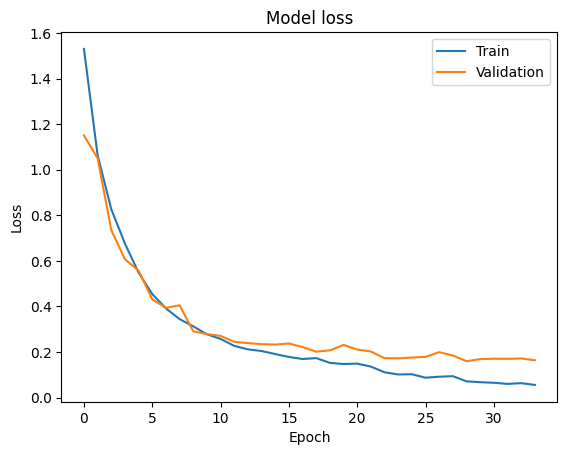

In [ ]:
import matplotlib.pyplot as plt

# plot the train and validation losses 
plt.plot(losses)
plt.plot(val_losses)
 
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.show()

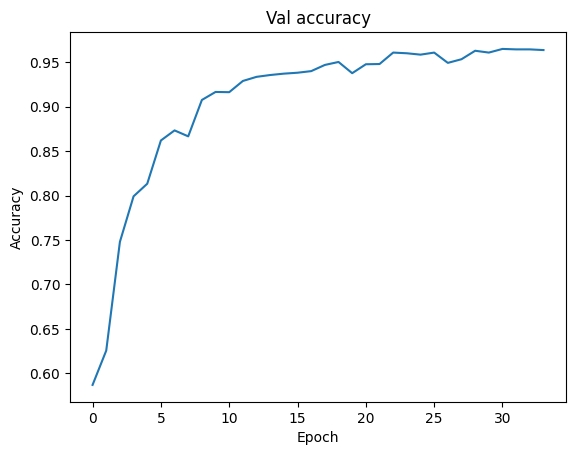

In [ ]:
# plot the train and validation losses 
plt.plot(val_accs)

plt.title('Val accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

In [ ]:
# load the best model
best_model = CNN()
best_model.load_state_dict(torch.load('best-model.pt'))
best_model = best_model.to(device)

### Evaluate the model on test set

In [ ]:
# define the test function 
def test(model, device, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    time = []
    with torch.no_grad():
        # iterate over test data
        for input, target in test_loader:
            input, target = input.to(device), target.to(device)

            # compute the time for the forward pass
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            output = model(input) 
            end_event.record()
            torch.cuda.synchronize()
            time.append(start_event.elapsed_time(end_event))

            # convert output probabilities to predicted class
            _, preds = torch.max(output, dim=1)
          
            correct += (preds == target).sum().item()
    
    acc = correct / len(test_loader.dataset)
    samples_per_msec = len(test_loader.dataset) / np.sum(time)

    return acc, samples_per_msec


# find test accuracy and print it
test_acc, samples_per_msec = test(best_model, device, test_dataloader)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.922


#### Estimate the speed of inference for a model

In [ ]:
# evaluate speed of a model in samples per second
print(f'Number of samples per millisecond: {int(samples_per_msec)}')

Number of samples per millisecond: 65


#### Visualize the results

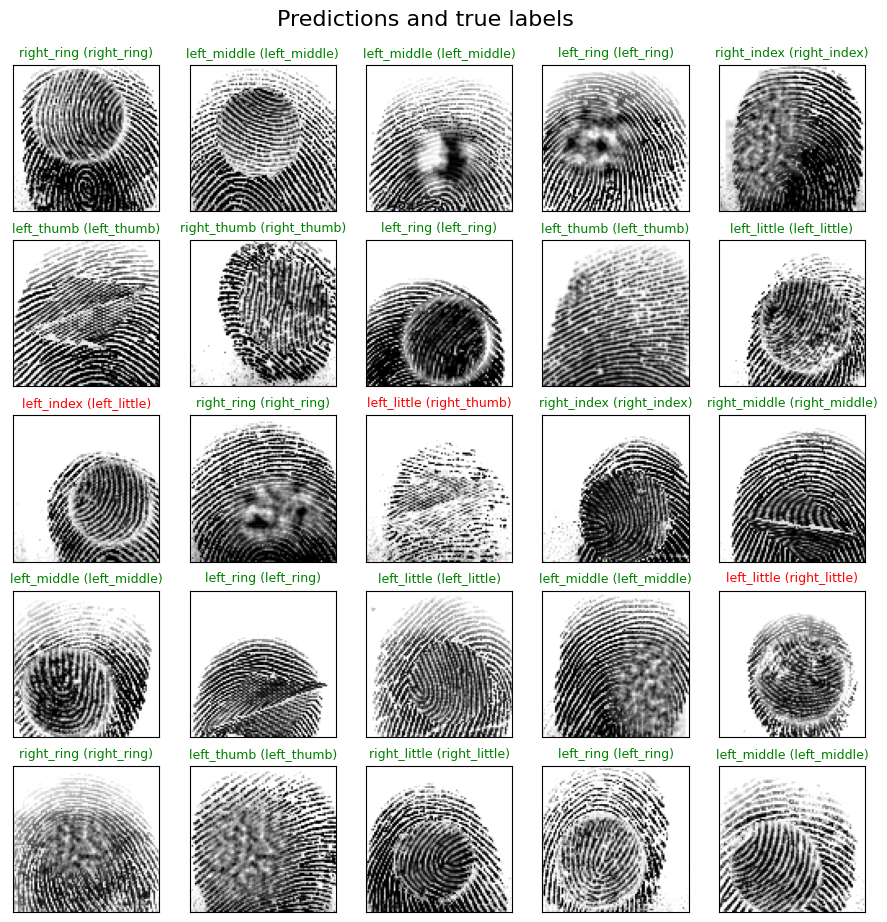

In [ ]:
# get one batch of test images
images, labels = next(iter(test_dataloader))

# get sample outputs
output = model(images.to(device))
_, preds = torch.max(output, dim=1)

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(11, 11))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title('{} ({})'.format(
        str(label_titles[preds[i]]), str(label_titles[labels[i]])),
        color=('g' if preds[i]==labels[i] else 'r'),
        fontsize=9)
    

plt.suptitle('Predictions and true labels', 
             fontsize=16, y=0.93)
plt.show()

1. Preprocessing techniques used:
    - For the preprocessing of the images, I applied the following transformations:
        *  Firstly, I observed that the images had different sizes. To fix this, I resized them to the smallest size among original images (103×96). Then, I detected some strange gray borders on the left and black borders on the right side of the images. To remove these borders, I cropped the images. After performing these steps the size of images was defined as 90x90.
        *  The original images were already in grayscale format. Therefore, there was no need to perform any grayscale conversion during the preprocessing stage.
        *  Finally, I converted the images into tensors and normalized them to help the model perform better.
2. Data augmentation techniques applied:
    - I applied a rotation of the image within the range of -5 to 5 degrees, which randomly applies to images with a probability of 0.6. (I tried various values of probabilities in `RandomApply`, however, with the probability equal to 0.6 the model provided the best performance)
3. Constructing the CNN architecture:
    - The process of tuning a model architecture involves several steps. First, determine the output layer dimensionality. It was set to match the number of label classes in the dataset, which is 10 for this task.
    - Then, the model architecture from the "Fingerprint Classification Using Deep Convolutional Neural Network" [paper](https://www.sciencepublishinggroup.com/journal/paperinfo?journalid=239&doi=10.11648/j.jeee.20210905.11) was used as a starting point.
    - Once the model architecture from the paper is used as the starting point, various modifications are tried, such as trying the different numbers of layers, adding padding to convolutional layers if needed, and adding new Dropout layer to reduce overfitting and Batch Normalization layers to speed up convergence.
4. Other techniques that was used for improving model’s performance:
    - In addition to using data augmentation, I applied several other techniques to improve my model's performance. One of them is Early Stopping, which helps to prevent overfitting by stopping the training process when the validation loss no longer improves after some patience (5 epochs). 
    - I also used a LR scheduling - ReduceLROnPlateau, which reduces the learning rate by 0.7 when the validation loss doesn't improve for more than 3 epochs. 
    - Additionally, I added new layers to the model architecture, specifically Dropout and BatchNorm, which can improve the model's generalization and reduce overfitting.